# Librerias

In [2]:
# Librerías estándar de Python y manipulación de datos
import os
import numpy as np
import pandas as pd
from collections import Counter
import shutil

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow y Keras
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, backend as K
from tensorflow.keras.models import Model, Sequential  # Asegurarse de tener Sequential
from tensorflow.keras.optimizers.legacy import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.applications import (
    EfficientNetB0, ResNet50, EfficientNetB4, EfficientNetB5, MobileNetV2, InceptionV3, Xception, MobileNetV3Small, EfficientNetB6
)

# Asegurarse de tener modelos preentrenados disponibles
from tensorflow.keras.applications import VGG16, VGG19  # Otras opciones de redes preentrenadas

# Machine Learning y métricas de rendimiento
from sklearn.metrics import (
    classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, 
    precision_recall_curve, roc_curve, auc
)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split, GridSearchCV  # GridSearchCV para buscar hiperparámetros

# PyTorch (si es necesario para alguna parte del proyecto)
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

# Weights and Biases (WandB) para monitorizar los experimentos
import wandb
from wandb.integration.keras import WandbCallback

# Manejo de logs y control de depuración
import logging
logging.basicConfig(level=logging.INFO)  # Para depuración y seguimiento del proceso

# Clasificación Multiclase 

## Modelo EfficientNetB0

In [2]:
# Inicializar Weights & Biases 
wandb.login()
wandb.init(project='clasificacion-celulas', entity='tp3-td6', name='EfficientNetB0-dataBalanceada')

# Configuración de directorios y generadores de datos
train_dir = 'data_split/train'
val_dir = 'data_split/val'
test_dir = 'data_split/test'

IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

# Configuración del generador de datos con augmentación
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,  
    width_shift_range=0.05,  
    height_shift_range=0.05,  
    brightness_range=[0.9, 1.1],  
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,  # Importante para evaluaciones
)

# Cargar y configurar el modelo EfficientNetB0
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Descongelar todas las capas excepto las primeras 100 capas
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
wandb_callback = WandbCallback(save_model=False)

# Entrenamiento del modelo
model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr, model_checkpoint, wandb_callback]
)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(test_generator)
print(f"Precisión en el conjunto de prueba: {test_acc:.4f}")

# Loggear los resultados en WandB
wandb.log({'test_loss': test_loss, 'test_accuracy': test_acc})
wandb.finish()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: azulnogueraa. Use `wandb login --relogin` to force relogin
wandb: Currently logged in as: azulnogueraa (tp3-td6). Use `wandb login --relogin` to force relogin


Found 8097 images belonging to 6 classes.
Found 1847 images belonging to 6 classes.
Found 2309 images belonging to 6 classes.


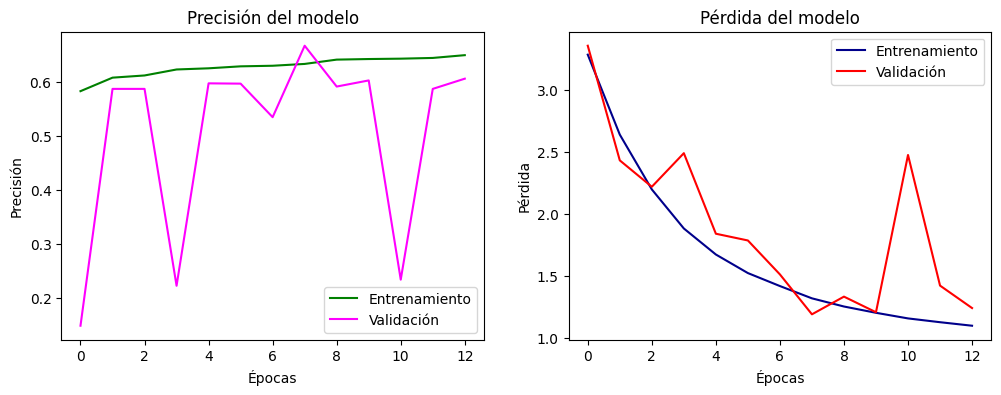

In [ ]:
# Establecer una figura para alojar ambos gráficos
plt.figure(figsize=(12, 4))  # Ajusta el tamaño total de la figura

# Gráfica de precisión
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
plt.plot(history.history['accuracy'], label='Entrenamiento', color='green')  # color verde para entrenamiento
plt.plot(history.history['val_accuracy'], label='Validación', color='magenta')  # color magenta para validación
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de pérdida
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
plt.plot(history.history['loss'], label='Entrenamiento', color='darkblue')  # color azul oscuro para entrenamiento
plt.plot(history.history['val_loss'], label='Validación', color='red')  # color rojo para validación
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Mostrar los gráficos
plt.show()


# Generar predicciones
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Reporte de clasificación
print(classification_report(y_true, y_pred, target_names=class_labels))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión')
plt.show()

## Modelo EfficientNetB4

In [2]:
# Inicializar Weights & Biases 
wandb.login()
wandb.init(project='clasificacion-celulas', entity='tp3-td6', name='EfficientNetB4-balanceado')

# Configuración de directorios y generadores de datos
train_dir = 'data_split/train'
val_dir = 'data_split/val'
test_dir = 'data_split/test'

IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

# Configuración del generador de datos con augmentación
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,  
    width_shift_range=0.05,  
    height_shift_range=0.05,  
    brightness_range=[0.9, 1.1],  
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,  # Importante para evaluaciones
)

# Cargar el modelo base EfficientNetB4 preentrenado
base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Descongelar todas las capas excepto las primeras 100 capas
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs, outputs)


model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
wandb_callback = WandbCallback(save_model=False)

# Entrenamiento del modelo
model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr, model_checkpoint, wandb_callback]
)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(test_generator)
print(f"Precisión en el conjunto de prueba: {test_acc:.4f}")

# Loggear los resultados en WandB
wandb.log({'test_loss': test_loss, 'test_accuracy': test_acc})
wandb.finish()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: azulnogueraa. Use `wandb login --relogin` to force relogin
wandb: Currently logged in as: azulnogueraa (tp3-td6). Use `wandb login --relogin` to force relogin


Found 8097 images belonging to 6 classes.
Found 1847 images belonging to 6 classes.
Found 2309 images belonging to 6 classes.


NameError: name 'history' is not defined

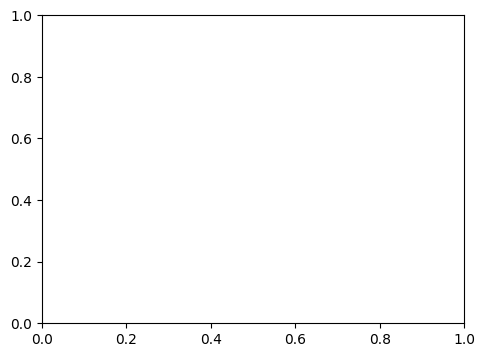

In [7]:
# Establecer una figura para alojar ambos gráficos
plt.figure(figsize=(12, 4))  # Ajusta el tamaño total de la figura

# Gráfica de precisión
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
plt.plot(history.history['accuracy'], label='Entrenamiento', color='green')  # color verde para entrenamiento
plt.plot(history.history['val_accuracy'], label='Validación', color='magenta')  # color magenta para validación
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de pérdida
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
plt.plot(history.history['loss'], label='Entrenamiento', color='darkblue')  # color azul oscuro para entrenamiento
plt.plot(history.history['val_loss'], label='Validación', color='red')  # color rojo para validación
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Mostrar los gráficos
plt.show()

# Generar predicciones
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Reporte de clasificación
print(classification_report(y_true, y_pred, target_names=class_labels))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión')
plt.show()

## Modelo EfficientNetB5

In [2]:
# Inicializar WandB
wandb.login()
wandb.init(project='clasificacion-celulas', name='EfficientNetB5')

# Configuración de directorios y generadores de datos
train_dir = 'data_split/train'
val_dir = 'data_split/val'
test_dir = 'data_split/test'

IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

# Configuración del generador de datos con augmentación
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,  
    width_shift_range=0.05,  
    height_shift_range=0.05,  
    brightness_range=[0.9, 1.1],  
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,  # Importante para evaluaciones
)

# Cargar el modelo base EfficientNetB4 preentrenado
base_model = EfficientNetB5(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Descongelar todas las capas excepto las primeras 100 capas
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
wandb_callback = WandbCallback(save_model=False)

# Entrenamiento del modelo
model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr, model_checkpoint, wandb_callback]
)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(test_generator)
print(f"Precisión en el conjunto de prueba: {test_acc:.4f}")

# Loggear los resultados en WandB
wandb.log({'test_loss': test_loss, 'test_accuracy': test_acc})
wandb.finish()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: azulnogueraa (tp3-td6). Use `wandb login --relogin` to force relogin


Found 7378 images belonging to 6 classes.
Found 1847 images belonging to 6 classes.
Found 2309 images belonging to 6 classes.


The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.


NameError: name 'history' is not defined

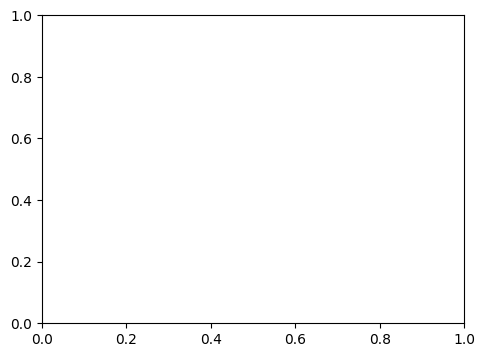

In [8]:
# Establecer una figura para alojar ambos gráficos
plt.figure(figsize=(12, 4))  # Ajusta el tamaño total de la figura

# Gráfica de precisión
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
plt.plot(history.history['accuracy'], label='Entrenamiento', color='green')  # color verde para entrenamiento
plt.plot(history.history['val_accuracy'], label='Validación', color='magenta')  # color magenta para validación
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de pérdida
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
plt.plot(history.history['loss'], label='Entrenamiento', color='darkblue')  # color azul oscuro para entrenamiento
plt.plot(history.history['val_loss'], label='Validación', color='red')  # color rojo para validación
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Mostrar los gráficos
plt.show()

# Generar predicciones
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Reporte de clasificación
print(classification_report(y_true, y_pred, target_names=class_labels))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión')
plt.show()

## Modelo MobileNetV2

In [ ]:
# Inicializar WandB
wandb.login()
wandb.init(project='clasificacion-celulas', name='MobileNetV2')

# Configuración de directorios y generadores de datos
train_dir = 'data_split/train'
val_dir = 'data_split/val'
test_dir = 'data_split/test'
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

# Generador de datos con augmentación
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,  
    width_shift_range=0.05,  
    height_shift_range=0.05,  
    brightness_range=[0.9, 1.1],  
    horizontal_flip=True
)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Cargar el modelo base MobileNetV2 preentrenado
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = True

# Descongelar las capas necesarias para ajuste fino
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Construir el modelo
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)
model_checkpoint = ModelCheckpoint('best_model_mobilenet.h5', monitor='val_loss', save_best_only=True, verbose=1)
wandb_callback = WandbCallback(save_model=False)

# Entrenamiento del modelo
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr, model_checkpoint, wandb_callback]
)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(test_generator)
print(f"Precisión en el conjunto de prueba: {test_acc:.4f}")

# Loggear los resultados en WandB
wandb.log({'test_loss': test_loss, 'test_accuracy': test_acc})
wandb.finish()

wandb: WARNING Fatal error while uploading data. Some run data will not be synced, but it will still be written to disk. Use `wandb sync` at the end of the run to try uploading.


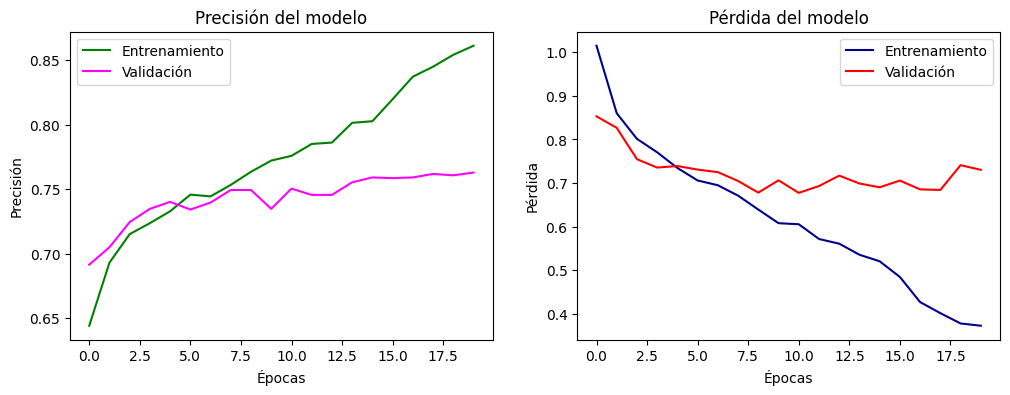

In [144]:
# Graficar precisión y pérdida
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento', color='green')
plt.plot(history.history['val_accuracy'], label='Validación', color='magenta')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento', color='darkblue')
plt.plot(history.history['val_loss'], label='Validación', color='red')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.show()

# Generar predicciones
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Reporte de clasificación
print(classification_report(y_true, y_pred, target_names=class_labels))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión')
plt.show()

## Modelo MobileNetV3

In [ ]:
# Inicializar WandB
wandb.login()
wandb.init(project='clasificacion-celulas', name='MobileNetV3')

# Configuración de directorios y generadores de datos
train_dir = 'data_split/train'
val_dir = 'data_split/val'
test_dir = 'data_split/test'
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

# Generador de datos con augmentación
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,  
    width_shift_range=0.05,  
    height_shift_range=0.05,  
    brightness_range=[0.9, 1.1],  
    horizontal_flip=True
)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Cargar el modelo base MobileNetV2 preentrenado
base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = True

# Descongelar las capas necesarias para ajuste fino
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Construir el modelo
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)
model_checkpoint = ModelCheckpoint('best_model_mobilenet.h5', monitor='val_loss', save_best_only=True, verbose=1)
wandb_callback = WandbCallback(save_model=False)

# Entrenamiento del modelo
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr, model_checkpoint, wandb_callback]
)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(test_generator)
print(f"Precisión en el conjunto de prueba: {test_acc:.4f}")

# Loggear los resultados en WandB
wandb.log({'test_loss': test_loss, 'test_accuracy': test_acc})
wandb.finish()

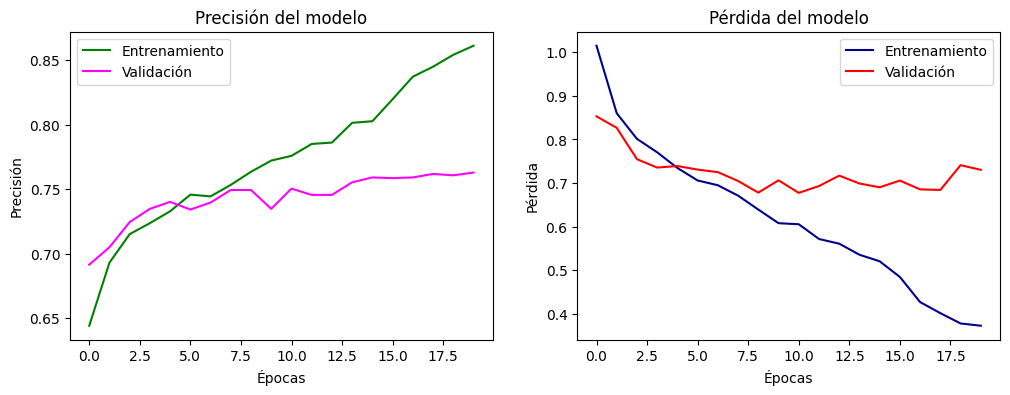

In [ ]:
# Graficar precisión y pérdida
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento', color='green')
plt.plot(history.history['val_accuracy'], label='Validación', color='magenta')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento', color='darkblue')
plt.plot(history.history['val_loss'], label='Validación', color='red')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.show()

# Generar predicciones
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Reporte de clasificación
print(classification_report(y_true, y_pred, target_names=class_labels))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión')
plt.show()

## Modelo InceptionV3

In [8]:
# Inicializar WandB
wandb.login()
wandb.init(project='clasificacion-celulas', name='InceptionV3')

# Configuración de directorios y generadores de datos
train_dir = 'data_split/train'
val_dir = 'data_split/val'
test_dir = 'data_split/test'
IMG_HEIGHT, IMG_WIDTH = 299, 299  # InceptionV3 requiere imágenes de 299x299
BATCH_SIZE = 32

# Generador de datos con augmentación
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,  
    width_shift_range=0.05,  
    height_shift_range=0.05,  
    brightness_range=[0.9, 1.1],  
    horizontal_flip=True
)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Importar y Definir el Modelo InceptionV3
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = True

# Descongelar las capas necesarias para ajuste fino
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Construir el modelo
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)
model_checkpoint = ModelCheckpoint('best_model_inception.h5', monitor='val_loss', save_best_only=True, verbose=1)
wandb_callback = WandbCallback(save_model=False)

# Entrenamiento del modelo
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr, model_checkpoint, wandb_callback]
)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(test_generator)
print(f"Precisión en el conjunto de prueba: {test_acc:.4f}")

# Loggear los resultados en WandB
wandb.log({'test_loss': test_loss, 'test_accuracy': test_acc})
wandb.finish()

Found 7378 images belonging to 6 classes.
Found 1847 images belonging to 6 classes.
Found 2309 images belonging to 6 classes.


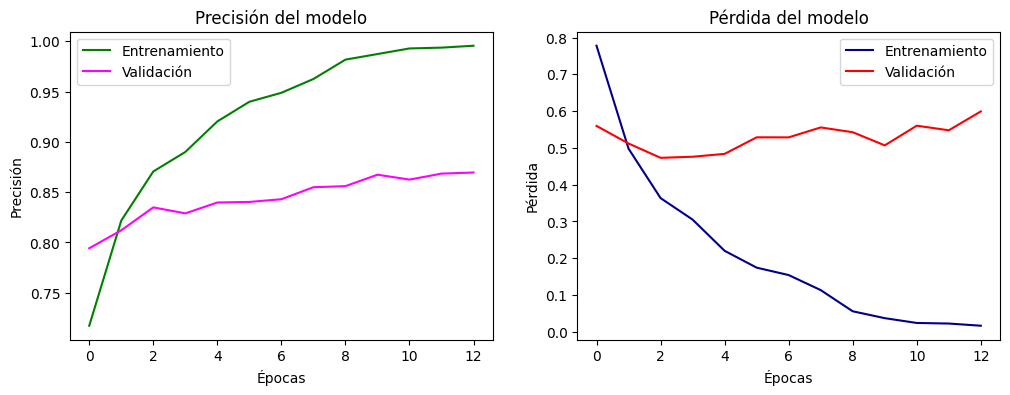

In [6]:
# Graficar precisión y pérdida
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento', color='green')
plt.plot(history.history['val_accuracy'], label='Validación', color='magenta')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento', color='darkblue')
plt.plot(history.history['val_loss'], label='Validación', color='red')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.show()

# Generar predicciones
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Reporte de clasificación
print(classification_report(y_true, y_pred, target_names=class_labels))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión')
plt.show()

## Modelo Xception

In [4]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import wandb
from wandb.integration.keras import WandbCallback

class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision_value = self.precision.result()
        recall_value = self.recall.result()
        return 2 * ((precision_value * recall_value) / (precision_value + recall_value + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

# Inicializar WandB
wandb.login()
wandb.init(project='clasificacion-celulas', entity='tp3-td6', name='Xception-balanceado')

# Configuración de directorios y generadores de datos
train_dir = 'data_split/train'
val_dir = 'data_split/val'
test_dir = 'data_split/test'
IMG_HEIGHT, IMG_WIDTH = 299, 299  # Xception también requiere 299x299
BATCH_SIZE = 32

# Generador de datos con augmentación
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,  
    width_shift_range=0.05,  
    height_shift_range=0.05,  
    brightness_range=[0.9, 1.1],  
    horizontal_flip=True
)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Importar y Definir el Modelo Xception
base_model = Xception(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = True

# Descongelar las capas necesarias para ajuste fino
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Construir el modelo
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

# Compilar el modelo con las métricas adicionales
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy', 
                       tf.keras.metrics.Precision(name='precision'), 
                       tf.keras.metrics.Recall(name='recall'), 
                       F1Score()])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)
model_checkpoint = ModelCheckpoint('best_model_xception.h5', monitor='val_loss', save_best_only=True, verbose=1)
wandb_callback = WandbCallback(save_model=False)

# Entrenamiento del modelo
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr, model_checkpoint, wandb_callback]
)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc, test_precision, test_recall, test_f1 = model.evaluate(test_generator)
print(f"Pérdida en el conjunto de prueba: {test_loss:.4f}")
print(f"Precisión en el conjunto de prueba: {test_acc:.4f}")
print(f"Precision en el conjunto de prueba: {test_precision:.4f}")
print(f"Recall en el conjunto de prueba: {test_recall:.4f}")
print(f"F1-Score en el conjunto de prueba: {test_f1:.4f}")

# Loggear los resultados en WandB
wandb.log({'test_loss': test_loss, 
           'test_accuracy': test_acc,
           'test_precision': test_precision,
           'test_recall': test_recall,
           'test_f1': test_f1})

wandb.finish()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Found 8097 images belonging to 6 classes.
Found 1847 images belonging to 6 classes.
Found 2309 images belonging to 6 classes.


Epoch 1/20
254/254 [==============================] - ETA: 0s - loss: 0.9125 - accuracy: 0.6674 - precision: 0.8241 - recall: 0.5213 - f1_score: 0.6386

/Users/achula/miniconda3/envs/td8/lib/python3.8/site-packages/keras/src/engine/training.py:2620: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()



Epoch 1: val_loss improved from inf to 0.64981, saving model to best_model_xception.h5
254/254 [==============================] - 774s 3s/step - loss: 0.9125 - accuracy: 0.6674 - precision: 0.8241 - recall: 0.5213 - f1_score: 0.6386 - val_loss: 0.6498 - val_accuracy: 0.7596 - val_precision: 0.8455 - val_recall: 0.6578 - val_f1_score: 0.7400 - lr: 1.0000e-04
Epoch 2/20


/Users/achula/miniconda3/envs/td8/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


254/254 [==============================] - ETA: 0s - loss: 0.5839 - accuracy: 0.7830 - precision: 0.8580 - recall: 0.7073 - f1_score: 0.7754
Epoch 2: val_loss improved from 0.64981 to 0.56866, saving model to best_model_xception.h5
254/254 [==============================] - 781s 3s/step - loss: 0.5839 - accuracy: 0.7830 - precision: 0.8580 - recall: 0.7073 - f1_score: 0.7754 - val_loss: 0.5687 - val_accuracy: 0.7861 - val_precision: 0.8453 - val_recall: 0.7250 - val_f1_score: 0.7805 - lr: 1.0000e-04
Epoch 3/20
254/254 [==============================] - ETA: 0s - loss: 0.4355 - accuracy: 0.8423 - precision: 0.8849 - recall: 0.7921 - f1_score: 0.8360
Epoch 3: val_loss improved from 0.56866 to 0.53031, saving model to best_model_xception.h5
254/254 [==============================] - 766s 3s/step - loss: 0.4355 - accuracy: 0.8423 - precision: 0.8849 - recall: 0.7921 - f1_score: 0.8360 - val_loss: 0.5303 - val_accuracy: 0.8078 - val_precision: 0.8508 - val_recall: 0.7748 - val_f1_score: 0.8

accuracy,▁▄▅▆▆▇▇▇█████
epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
f1_score,▁▄▅▆▆▇▇██████
loss,█▅▄▃▃▂▂▂▁▁▁▁▁
lr,████████▁▁▁▁▁
precision,▁▂▄▅▆▆▇▇█████
recall,▁▄▅▆▇▇▇██████
test_accuracy,▁
test_f1,▁
test_loss,▁
test_precision,▁


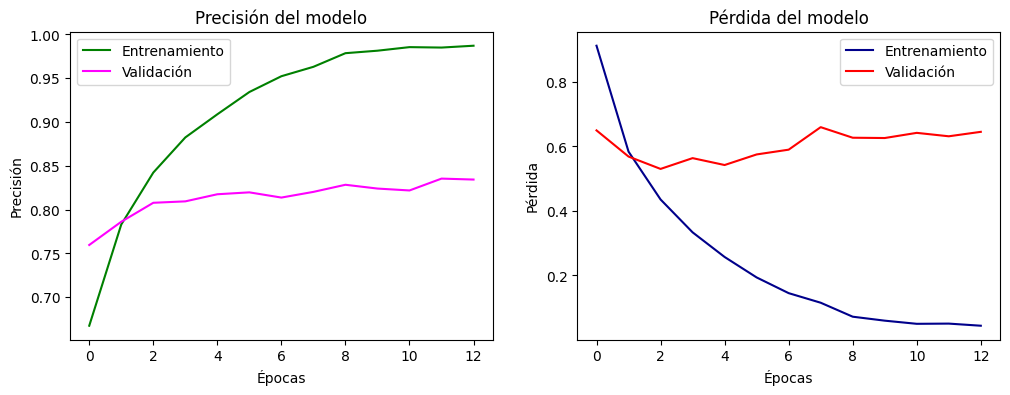

73/73 [==============================] - 122s 2s/step
              precision    recall  f1-score   support

       ASC-H       0.12      0.06      0.08       185
      ASC-US       0.15      0.11      0.13       122
        HSIL       0.30      0.18      0.22       341
        LSIL       0.18      0.11      0.13       272
    Negative       0.65      0.82      0.72      1356
         SCC       0.09      0.06      0.07        33

    accuracy                           0.53      2309
   macro avg       0.25      0.22      0.23      2309
weighted avg       0.46      0.53      0.49      2309



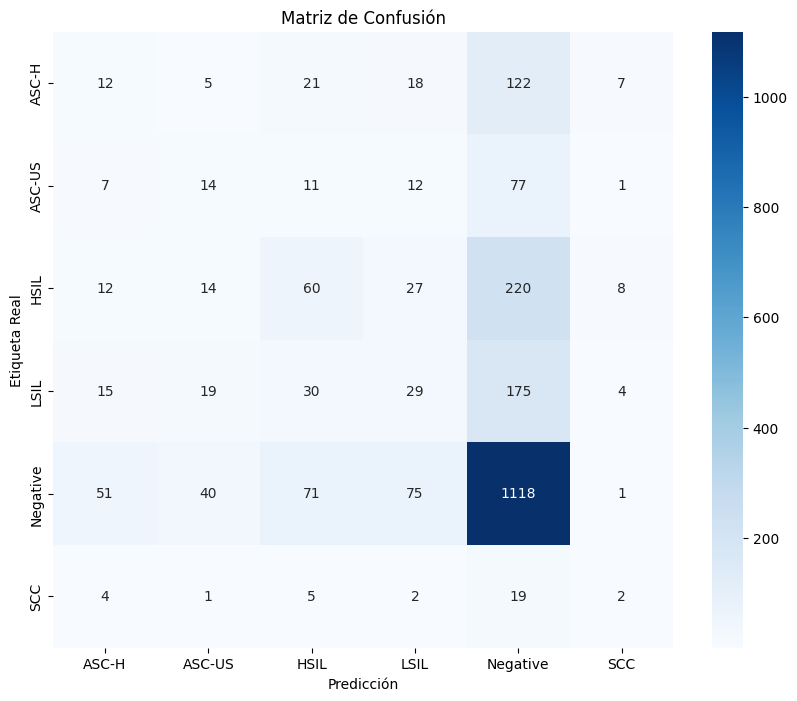

In [5]:
# Graficar precisión y pérdida
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento', color='green')
plt.plot(history.history['val_accuracy'], label='Validación', color='magenta')
plt.title('Accuracy del modelo')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento', color='darkblue')
plt.plot(history.history['val_loss'], label='Validación', color='red')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.show()

# Generar predicciones
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Reporte de clasificación
print(classification_report(y_true, y_pred, target_names=class_labels))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión')
plt.show()